In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download darshan1504/covid19-detection-xray-dataset

covid19-detection-xray-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip -q /content/covid19-detection-xray-dataset.zip

replace NonAugmentedTrain/BacterialPneumonia/0.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [77]:
import os
import glob
import h5py
import shutil
import imgaug as aug #augment data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt #plot stuff/show images
import matplotlib.image as mimg
import imgaug.augmenters as iaa #augment data(data is imbalanced)
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path #get data
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19,preprocess_input #transfer learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
#convolutional nueral networks
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
# %matplotlib inline


ImportError: ignored

In [8]:
import tensorflow as tf

In [9]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.experimental.list_physical_devices('GPU')

Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
#get data
data_dir1 = Path('../content')
data_dir2 = Path('../content/TrainData')
data_dir3 = Path('../content/ValData')
# data_dir4 = Path('../content/pneumonia-virus-vs-covid19/Pneumonia_and_COVID19')

In [11]:
data = []
normal_data = []
bacterial_data = []
viral_data = []
covid_data=[]

In [12]:
loop_dir2 = ['NonAugmentedTrain', 'ValData']

In [13]:
for i in loop_dir2:
    normal_dir2 = data_dir1 / i / 'Normal'
    bacterial_dir2 = data_dir1 / i / 'BacterialPneumonia'
    viral_dir2 = data_dir1 / i / 'ViralPneumonia'
    covid_dir2=data_dir1/i/'COVID-19'
    normal_cases2 = normal_dir2.glob('*.jpeg')
    bacterial_cases2 = bacterial_dir2.glob('*.jpeg')
    viral_cases2 = viral_dir2.glob('*.jpeg')
    covid_cases2 = covid_dir2.glob('*.jpeg')
    for img in normal_cases2:
        normal_data.append((img,0))
    for img in bacterial_cases2:
      bacterial_data.append((img,1))
    for img in viral_cases2:
        viral_data.append((img,2))
    for img in covid_cases2:
      covid_data.append((img,3))

In [14]:
print('number of normal cases: ' + str(len(normal_data)))

number of normal cases: 1330


In [15]:
print('number of bacterial cases: ' + str(len(bacterial_data)))

number of bacterial cases: 974


In [16]:
print('number of viral cases: ' + str(len(viral_data)))

number of viral cases: 617


In [17]:
print('number of covid cases: ' + str(len(covid_data)))

number of covid cases: 69


In [18]:
str(len(normal_data))

'1330'

In [19]:
data = normal_data + bacterial_data + viral_data+covid_data

In [20]:
str(len( data))

'2990'

In [21]:
del normal_data, bacterial_data, viral_data, covid_data

In [22]:
data = pd.DataFrame(data, columns=['image', 'label'],index=None)

In [23]:
#shuffle
data = data.sample(frac=1.).reset_index(drop=True)

In [24]:
#print
data.head()

,image,label
0,../content/NonAugmentedTrain/BacterialPneumoni...,1
1,../content/ValData/ViralPneumonia/154.jpeg,2
2,../content/NonAugmentedTrain/BacterialPneumoni...,1
3,../content/ValData/BacterialPneumonia/163.jpeg,1
4,../content/NonAugmentedTrain/ViralPneumonia/39...,2


In [25]:
# Get the counts for each class
cases_count = data['label'].value_counts()
print(cases_count)

0    1330
1     974
2     617
3      69
Name: label, dtype: int64


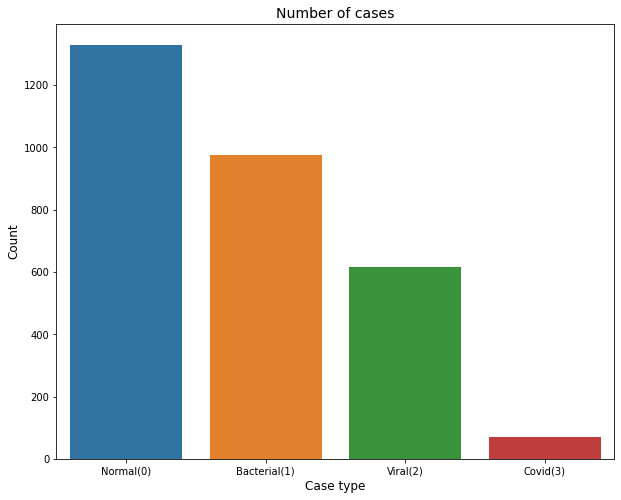

In [26]:
# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Bacterial(1)', 'Viral(2)','Covid(3)'])
plt.show()

In [27]:
del cases_count

In [28]:
#show sample
viral_samples = (data[data['label']==2]['image'].iloc[:5]).tolist()
bacterial_samples = (data[data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (data[data['label']==0]['image'].iloc[:5]).tolist()
covid_samples = (data[data['label']==3]['image'].iloc[:5]).tolist()

In [29]:
# Concat the data in a single list and del the above 3 lists
samples = viral_samples + bacterial_samples + normal_samples+covid_samples

In [30]:
del viral_samples, normal_samples, bacterial_samples,covid_samples

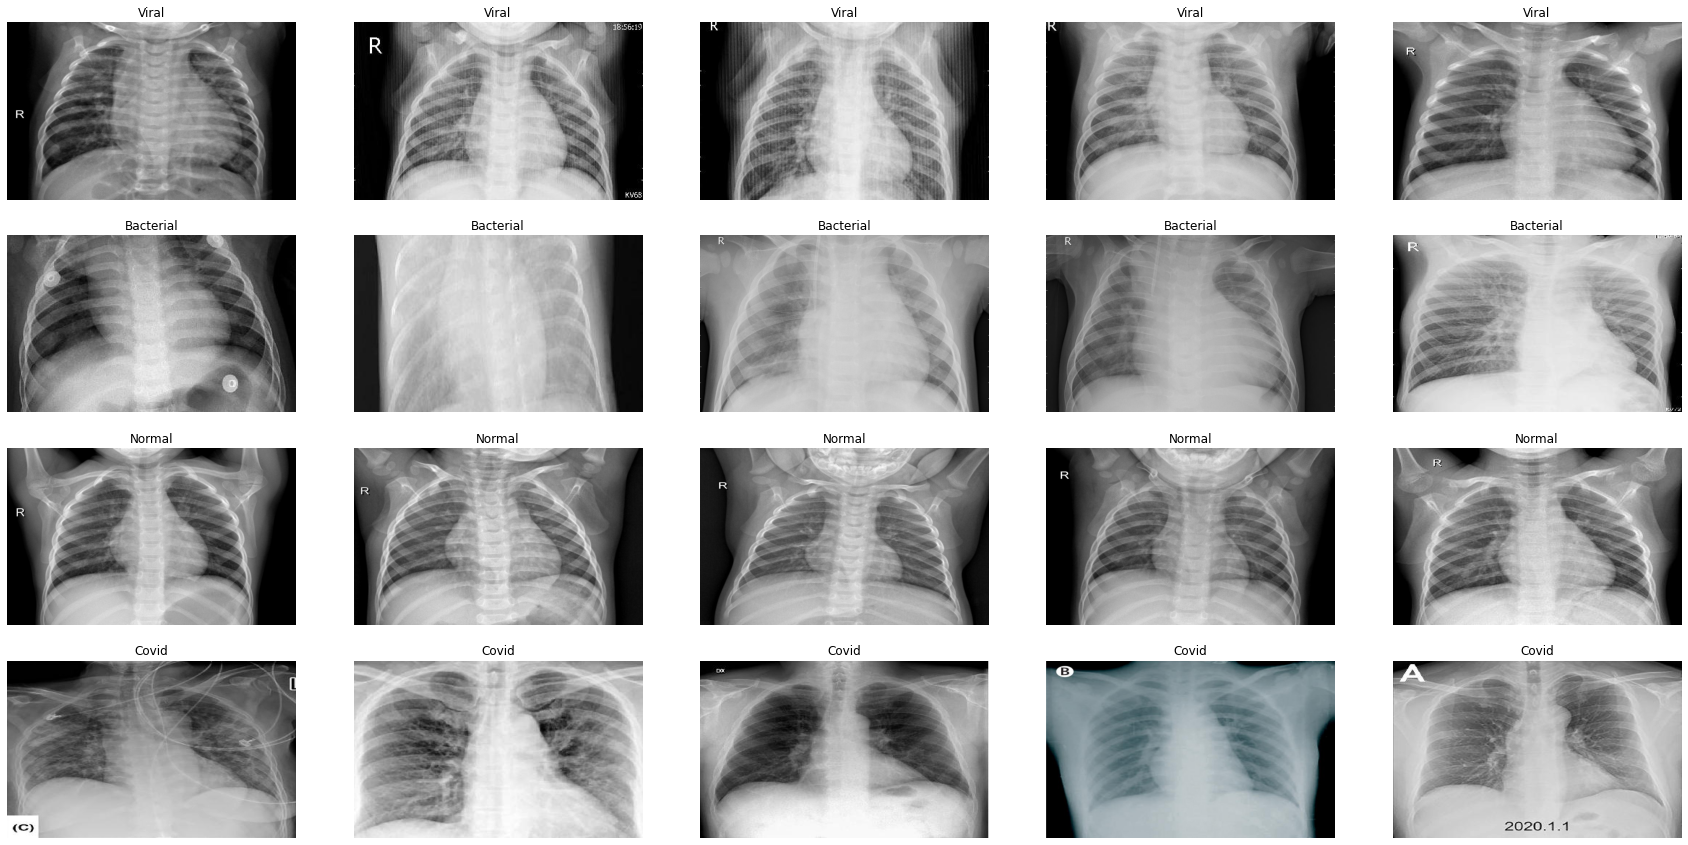

In [31]:
# Plot the data 
f, ax = plt.subplots(4,5, figsize=(30,15))
for i in range(20):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Viral")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Bacterial")
    elif i>=10 and i<15:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Covid")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')

In [32]:
plt.show()

In [33]:
data = data.iloc[: int(data.shape[0]/2)]

In [34]:
print(data)

                                                  image  label
0     ../content/NonAugmentedTrain/BacterialPneumoni...      1
1            ../content/ValData/ViralPneumonia/154.jpeg      2
2     ../content/NonAugmentedTrain/BacterialPneumoni...      1
3        ../content/ValData/BacterialPneumonia/163.jpeg      1
4     ../content/NonAugmentedTrain/ViralPneumonia/39...      2
...                                                 ...    ...
1490     ../content/ValData/BacterialPneumonia/302.jpeg      1
1491     ../content/ValData/BacterialPneumonia/210.jpeg      1
1492       ../content/NonAugmentedTrain/Normal/340.jpeg      0
1493                 ../content/ValData/Normal/231.jpeg      0
1494                  ../content/ValData/Normal/60.jpeg      0

[1495 rows x 2 columns]


In [35]:
print(data.shape)

(1495, 2)


In [36]:
image_data = []
label_data = []

In [37]:
for index, d in data.iterrows():
    img = d['image']
    l = d['label']
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(l, num_classes=4)
    image_data.append(img)
    label_data.append(label)

In [38]:
image_data = np.array(image_data)
label_data = np.array(label_data)

In [39]:
del data

In [40]:
image_train, image_validate, image_test = np.split(image_data, [int(.7*len(image_data)), int(.85*len(image_data))])

In [41]:
label_train, label_validate, label_test = np.split(label_data, [int(.7*len(label_data)), int(.85*len(label_data))])

In [42]:
print('number of training images and labels: ' + str(len(image_train)) + ' and ' + str(len(label_train)))

number of training images and labels: 1046 and 1046


In [43]:
print('number of validation images and labels: ' + str(len(image_validate)) + ' and ' + str(len(label_validate)))

number of validation images and labels: 224 and 224


In [44]:
print('number of test images and labels: ' + str(len(image_test)) + ' and ' + str(len(label_test)))

number of test images and labels: 225 and 225


In [45]:
del image_data, label_data

In [98]:
from keras.applications.resnet import ResNet50

In [99]:
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)


94765736/94765736 [==============================] - 5s 0us/step


In [100]:
from tensorflow import keras
from tensorflow.keras import layers

In [101]:
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(4, activation = 'softmax')
])

In [102]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = 'accuracy'
)

In [103]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 4)                 401412    
                                                                 
Total params: 23,989,124
Trainable params: 23,936,004
Non-trainable params: 53,120
_________________________________________________________________


In [104]:
model.fit(
  
  
    image_train, label_train,
    epochs = 50,
    batch_size = 8,
    validation_data = (image_validate, label_validate),
    )

Epoch 1/50
131/131 [==============================] - 24s 127ms/step - loss: 1.2928 - accuracy: 0.7390 - val_loss: 4.6043 - val_accuracy: 0.2054
Epoch 2/50
131/131 [==============================] - 15s 111ms/step - loss: 0.3745 - accuracy: 0.8996 - val_loss: 7.3408 - val_accuracy: 0.2054
Epoch 3/50
131/131 [==============================] - 15s 112ms/step - loss: 0.1070 - accuracy: 0.9656 - val_loss: 5.7334 - val_accuracy: 0.3527
Epoch 4/50
131/131 [==============================] - 15s 113ms/step - loss: 0.2595 - accuracy: 0.9426 - val_loss: 4.2393 - val_accuracy: 0.2545
Epoch 5/50
131/131 [==============================] - 15s 114ms/step - loss: 0.2451 - accuracy: 0.9455 - val_loss: 6.0242 - val_accuracy: 0.2902
Epoch 6/50
131/131 [==============================] - 15s 111ms/step - loss: 0.3585 - accuracy: 0.9302 - val_loss: 2.4700 - val_accuracy: 0.3795
Epoch 7/50
131/131 [==============================] - 15s 113ms/step - loss: 0.1718 - accuracy: 0.9618 - val_loss: 1.0927 - val_ac

In [105]:
test_loss, test_score = model.evaluate(image_test, label_test, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

15/15 [==============================] - 3s 76ms/step - loss: 1.0629 - accuracy: 0.8044
Loss on test set:  1.0629204511642456
Accuracy on test set:  0.804444432258606


In [106]:
# Get predictions
preds = model.predict(image_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

15/15 [==============================] - 2s 55ms/step


In [107]:
# Original labels
orig_test_labels = np.argmax(label_test, axis=-1)

In [108]:
print(orig_test_labels.shape)
print(preds.shape)

(225,)
(225,)


<Figure size 432x288 with 0 Axes>

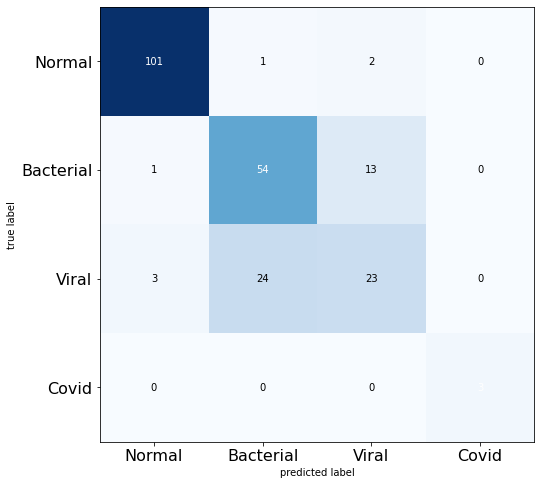

In [109]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(4), ['Normal', 'Bacterial', 'Viral','Covid'], fontsize=16)
plt.yticks(range(4), ['Normal', 'Bacterial', 'Viral','Covid'], fontsize=16)
plt.show()

In [110]:
from sklearn.metrics import precision_recall_fscore_support, recall_score, precision_score

In [111]:
precision_recall_fscore_support(orig_test_labels, preds, average='macro')

(0.8126780558992418, 0.8063178733031674, 0.8059820818279465, None)

In [112]:
precision_score(orig_test_labels, preds, average='weighted')

0.7990322924047107

In [113]:
nn, nb, nv,nc, bn, bb, bv,bc, vn, vb, vv,vc,cn,cb,cv,cc = cm.ravel()
normal_precision = nn/(nn+bn+vn+cn)
normal_recall = nn/(nn+nb+nv+nc)
bacterial_precision = bb/(nb+bb+vb+cb)
bacterial_recall = bb/(bn+bb+bv+bc)
viral_precision = vv/(nv+bv+vv+cv)
viral_recall = vv/(vn+vb+vv+vc)
covid_precision = cc/(nc+bc+vc+cc)
covid_recall = cc/(cn+cb+cv+cc)

In [114]:
normal_precision,normal_recall,bacterial_precision,bacterial_recall,viral_precision,viral_recall

(0.9619047619047619,
 0.9711538461538461,
 0.6835443037974683,
 0.7941176470588235,
 0.6052631578947368,
 0.46)

In [115]:
print("Recall of the model when dealing with heathly lungs is {:.2f}".format(normal_recall))
print("Precision of the model when dealing with heathly lungs is {:.2f}".format(normal_precision))
print("Recall of the model when dealing with bacterial pneumonia is {:.2f}".format(bacterial_recall))
print("Precision of the model when dealing with bacterial pneumonia is {:.2f}".format(bacterial_precision))
print("Recall of the model when dealing with viral pneumonia is {:.2f}".format(viral_recall))
print("Precision of the model when dealing with viral pneumonia is {:.2f}".format(viral_precision))
print("Recall of the model when dealing with covid is {:.2f}".format(covid_recall))
print("Precision of the model when dealing with covid is {:.2f}".format(covid_precision))

Recall of the model when dealing with heathly lungs is 0.97
Precision of the model when dealing with heathly lungs is 0.96
Recall of the model when dealing with bacterial pneumonia is 0.79
Precision of the model when dealing with bacterial pneumonia is 0.68
Recall of the model when dealing with viral pneumonia is 0.46
Precision of the model when dealing with viral pneumonia is 0.61
Recall of the model when dealing with covid is 1.00
Precision of the model when dealing with covid is 1.00
